In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')

In [2]:
from xraycam.camalysis import fwhm
from scipy.ndimage.filters import gaussian_filter as gfilt
from scipy.interpolate import UnivariateSpline

In [128]:
def rebin_spectrum(x, y, rebin = 5):
    """
    Rebin `x` and `y` into arrays of length `int(len(x)/rebin)`. The
    highest-x bin is dropped in case len(x) isn't a multiple of rebin.
    x is assumed to be evenly-spaced and in ascending order.
    Returns: x, y
    """
    def group(arr1d, op = np.mean):
        """
        op: a function to evaluate on each new bin that returns a numeric value.
        >>> rebin = 3
        >>> group(range(10))
        [1.0, 4.0, 7.0]
        """
        import itertools
        i = itertools.count()
        def key(dummy):
            xindx = i.__next__()
            return int(xindx/rebin)
        return [op(list(values)) for groupnum, values in itertools.groupby(arr1d, key = key)][:-1]
    return group(x, np.mean), group(y, np.sum)

def energy_from_x_position(bragg,xpx,rebinparam=1,braggorder=1):
    """
    This function takes a bragg angle 'bragg', which is the bragg angle for a known
    energy on the camera, and takes an x position which is left (negative) or right (positive)
     of the central energy, in pixels 'xpx',
    and returns the energy of the x-ray which will be refocused to that position in the Rowland geometry.
    
    It is specific to Rowland diameter = 10cm, pixel size = 5.2 microns, and camera tangent to the circle.
    """
    pizel_size=2.9e-3 # NOTE: changed for new camera
    xpos=xpx*pizel_size*rebinparam
    return braggorder*1000*1.97705*np.sqrt(1+\
                           (xpos*np.cos(np.pi*bragg/90)+50*np.sin(np.pi*bragg/90))**2\
                           /(50-50*np.cos(np.pi*bragg/90)+xpos*np.sin(np.pi*bragg/90))**2)

def add_energy_scale(lineout,known_energy,known_bin=None,rebinparam=1,camerainvert=True,braggorder=1,**kwargs):
    """
    Returns an np array of [energies,lineout], by either applying a known energy to the max of the dataset, or to a specified bin.
    """
    if known_bin == None:
        centerindex=np.argmax(gfilt(lineout,3)) # if known_bin not provided, set energy to max of lineout
        # note to self, I was worried that gfilt might change the length of the list, but it doesn't.
    else:
        centerindex=round(known_bin/rebinparam) # else set energy to be at known bin position
    indexfromcenter=np.array(range(len(lineout)))-centerindex
    if camerainvert == True:
            indexfromcenter=-indexfromcenter # if camera gets flipped upside down, just reverse the indices
    return (energy_from_x_position(calc_bragg_angle(known_energy,braggorder),indexfromcenter,rebinparam,braggorder),lineout)
    
def calc_bragg_angle(energy,braggorder=1):
    """
    calculates bragg angle from energy given in eV.  Currently specific to si111 2d spacing.
    """
    si111_2dspacing=6.27118
    return 180*np.arcsin(12398.4*braggorder/(si111_2dspacing*energy))/np.pi
    
def plot_with_energy_scale(datarun,known_energy,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False,
                           label=None,calcfwhm=False,**kwargs):
    lineout = np.sum(datarun.get_array()[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=1)/datarun.photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    plt.plot(*lineout_energyscale,label=label)
    if show == True:
        plt.show()

def fwhm_ev(arr2d,fwhm_smooth=2):
    """
    Given a 2d-array of [energies(eV),lineout], calculate fwhm of peak in the lineout.
    """
    x, y = arr2d
    y = gfilt(y,fwhm_smooth)
    spline = UnivariateSpline(x, y - np.max(y)/2, s = 0)
    r1, r2 = spline.roots()
    return format(r2 - r1, '.3f')

def fwhm_datarun(datarun,known_energy,yrange=[0,-1],xrange=[0,-1],rebin=1,fwhm_smooth=2,**kwargs):
    """
    Given a 2d-array of [energies(eV),lineout], calculate fwhm of peak in the lineout.
    """
    lineout = np.sum(datarun.get_array()[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=1)/datarun.photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    x, y = lineout_energyscale
    y = gfilt(y,fwhm_smooth)
    spline = UnivariateSpline(x, y - np.max(y)/2, s = 0)
    r1, r2 = spline.roots()
    return format(r2 - r1, '.3f')

def focus_ZvsFWHM_plot(dataruntuple,known_energy,**kwargs):
    plt.plot(*list(zip(*[(x.run.z,fwhm_datarun(x.run,known_energy,**kwargs)) for x in 
                     dataruntuple])),label='fwhm v z')
    plt.show()
    
def cropping_tool(datarun,step,known_energy=2014,calcfwhm=True,**kwargs):
    [plot_with_energy_scale(datarun.run,known_energy,label='['+','.join((str(i),str(i+step)))+']',xrange=[i,i+step],
                            show=False,calcfwhm=calcfwhm,peaknormalize=True,**kwargs) for i in range(0,2000,step)]
    plt.show()
    
class Monitor:
    def __init__(self, *args, transpose = True, vmax = 150, rebin = 1, **kwargs):
        self.run = camcontrol.DataRun(*args, **kwargs)
        self.vmax = vmax
        self.rebin = rebin

    def frame(self):
        return self.run.get_frame()
    
    def update(self):
        self.run.show(vmax = self.vmax)
        self.run.plot_lineout(rebin = self.rebin)
        self.frame().plot_histogram(xmin = 0, xmax = self.vmax)
        
    def stop(self):
        self.run.stop()

In [117]:
from scipy.ndimage.filters import gaussian_filter as gfilt

def parabolic_sort(a, b, shape = (1024, 1280)):
    """
    Returns: z, (rowsort, colsort)
    
    z : 2d numpy array of shape `shape` with values x**2 + b * x + c,
    where x is row index.
    rowsort : sequence of row indices that sort z
    colsort : sequence of column indices that sort z
    """
    x, y = np.indices(shape, dtype = 'int')
    z = ((a * (x**2)) + (b * x) + y)
    return z, np.unravel_index(
                np.argsort(z.ravel()), z.shape)


def center_of_masses(arr2d):
    def _cm(arr1d):
        return np.dot(arr1d, np.arange(len(arr1d)))/np.sum(arr1d)
    return np.array(list(map(_cm, arr2d)))

def quadfit(arr2d, smooth = 0):
    """
    Return the second- and first-order coefficients for a parabolic
    fit to array of center of mass values of the rows of arr2d.
    """
    filtered = gfilt(arr2d, smooth)
    y = center_of_masses(filtered)# - np.percentile(filtered, 1))
    x = np.arange(len(y))
    good = np.where(np.isfinite(y))[0]
    a, b, c, = np.polyfit(x[good], y[good], 2)
    # For some reason a factor of -1 is needed
    return -a, -b, -c

def get_parabolic_lineout(arr2d, nbins = None):
    """Return lineout taken using parabolic bins"""
    a, b, _ = quadfit(arr2d)
    num_rows, num_cols = arr2d.shape
    if nbins is None:
        nbins = num_cols
    def chunks():
        """Return array values grouped into chunks, one per bin"""
        increment = int(num_rows * (num_cols/nbins))
        _, sort_indices = parabolic_sort(a, b, arr2d.shape)
        sort_data = arr2d[sort_indices].ravel()
        return [sort_data[i:i + increment] for i in range(0, len(sort_data), increment)]
    return np.array(list(map(np.sum, chunks())))

psurface, sort_indices = parabolic_sort(-7.23224111e-05,  8.57453753e-02)

import matplotlib.pyplot as mplt
def plot_parabolas(arr2d, interval = 10):
    a, b, _ = quadfit(arr2d)
    a, b = -a, -b
    x = np.arange(arr2d.shape[0])
    parabolas = [a * x**2 + b * x + c for c in range(0, arr2d.shape[1], interval)]
    [mplt.plot(p, x) for p in parabolas]
    
# We exclude the top and bottom of the frame to avoid boundary artifacts
#exclude_region = 0
#arr2d = salpha_full_analyzer.get_array()[250:-250, 500:800]

def normlineout(dat):
    lineout = np.sum(dat, axis = 0)
    return lineout/np.max(lineout)

def dofit(arr2d):

    y = center_of_masses(arr2d)
    x = np.arange(len(y))
    plt.plot(x, y, label = 'CM lineout')

    a, b, c = quadfit(arr2d)
    plt.plot(x, -a * x**2 - b * x - c)
    plt.show()

    # Also the 2d array overlaid with some of the bin-defining parabolas
    mplt.imshow(arr2d, vmax = 450)
    plot_parabolas(arr2d, interval = 15)
    mplt.show()
    
    plt.plot(get_parabolic_lineout(arr2d), label = 'parabolic lineout')
    #col_lineout = normlineout(arr2d)
    plt.plot(np.sum(arr2d, axis = 0), label = 'column lineout')
    plt.show()

    print(a, b, c) 
    
    return get_parabolic_lineout(arr2d)

In [102]:
def energy_from_x_position(bragg,xpx,rebinparam=1):
    xpos=xpx*5.2e-3*rebinparam
    return 1000*1.97705*np.sqrt(1+\
                           (xpos*np.cos(np.pi*bragg/90)+50*np.sin(np.pi*bragg/90))**2\
                           /(50-50*np.cos(np.pi*bragg/90)+xpos*np.sin(np.pi*bragg/90))**2)

def energy_scale(bragg,lineout,smooth=2,xpixelshift=0,rebinparam=1,camerainvert=True):
    """Note this is essentially exact, from raytracing considerations.  This produces a nonlinear pixel-to-energy mapping."""
    maxindex=np.argmax(gfilt(lineout,smooth))
    indexfromcenter=np.array(range(len(lineout)))-maxindex-xpixelshift
    if camerainvert == True:
        indexfromcenter=-indexfromcenter
    return energy_from_x_position(bragg,indexfromcenter,rebinparam)

def fixed_energy_scale(bragg,lineout,smooth=2,xpixelshift=0,rebinparam=1,camerainvert=True):
    """Note this is essentially exact, from raytracing considerations.  This produces a nonlinear pixel-to-energy mapping."""
    maxindex=312/rebinparam
    indexfromcenter=np.array(range(len(lineout)))-maxindex-xpixelshift
    if camerainvert == True:
        indexfromcenter=-indexfromcenter
    return energy_from_x_position(bragg,indexfromcenter,rebinparam)

def fwhmeV(bragg,lineout):
    """Note this is only a rough estimate!  The true energy scale is nonlinear, so this is just an approximation."""
    bandwidth = (energy_from_x_position(bragg,-1280/2)-energy_from_x_position(bragg,1280/2))
    eVperpixel = bandwidth/1280
    return round(fwhm(lineout)*eVperpixel,3)

def avgbandwidth(bragg):
    """Note this is only a rough estimate!  The true energy scale is nonlinear, so this is just an approximation."""
    return (energy_from_x_position(bragg,-1280/2)-energy_from_x_position(bragg,1280/2))

def plot_parabolic_energy_scale(bragg,datarun,label=None,show=True,yupper=400,ylower=None,xleft=100,xright=100,xpixelshift=0,smooth=2):
    lineout = normalize(get_parabolic_lineout(datarun.get_array()[yupper:ylower, CMcoord(datarun)-xleft:CMcoord(datarun)+xright]))
    plt.plot(energy_scale(bragg,lineout,smooth,xpixelshift),lineout,label=label)
    if show != False:
        plt.show()
        
def plot_with_energy_scale(bragg,datarun,label=None,show=True,yupper=250,ylower=750,xleft=200,xright=200,xpixelshift=0,smooth=2,calcfwhm=False,rebin=1,peaknormalize=True):
    lineout = np.sum(datarun.get_array()[yupper:ylower],axis=0)/datarun.photon_value#CMcoord(datarun)-xleft:CMcoord(datarun)+xright],axis=0))
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif calcfwhm != False:
        s='-'
        label=s.join((str(datarun),str(fwhmeV(bragg,gfilt(lineout,2)))))
    if rebin != 1:
        lineout=rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout=normalize(lineout)
    plt.plot(fixed_energy_scale(bragg,lineout,smooth,xpixelshift,rebinparam=rebin),lineout,label=label)
    if show != False:
        plt.show()
        
def plot_with_energy_scale_rebin(bragg,datarun,label=None,show=True,xpixelshift=0,smooth=2,rebinparam=1):
    lineout = datarun.get_frame().get_lineout(rebin=rebinparam)[1]
    plt.plot(energy_scale(bragg,lineout,smooth,xpixelshift,rebinparam),normalize(lineout),label=label)
    if show != False:
        plt.show()
        
def plot_parabolic_energy_scale_rebin(bragg,datarun,label=None,show=True,yupper=400,ylower=None,xleft=100,xright=100,xpixelshift=0,smooth=2,rebinparam=1):
    lineout = get_parabolic_lineout(np.transpose(datarun.get_array()[yupper:ylower, xleft:xright]))
    rebinlineout = rebin_spectrum(np.array(range(len(lineout))),lineout,rebinparam)
    plt.plot(fixed_energy_scale(bragg,rebinlineout[1],smooth,xpixelshift,rebinparam),normalize(rebinlineout[1]),label=label)
    if show != False:
        plt.show()
        
#abs(xright-xleft)/rebinparam

In [4]:
def center_of_masses(arr2d):
    def _cm(arr1d):
        return np.dot(arr1d, np.arange(len(arr1d)))/np.sum(arr1d)
    return np.array(list(map(_cm, arr2d)))

def cmplot(arr2d, smooth=0):

    y = center_of_masses(arr2d)
    x = np.arange(len(y))
    if smooth != 0:
        y = gfilt(y,smooth)
    plt.plot(x, y, label = 'CM lineout')
    plt.show()

# ZnS Kalpha - 4mm mask - focus to compare CdS
* Gain 213, Exposure 50ms
* 25 kV @ 1.5mA

In [24]:
focus0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus0.9.15')

Loaded from cache.


In [25]:
focus1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus1.9.15')

Loaded from cache.


In [8]:
focus3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus3.9.15',htime='1m')
focus3.run.z=0

starting acquisition


In [20]:
focus4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus4.9.15',htime='1m')
focus4.run.z=2

starting acquisition


In [31]:
focus5 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus5.9.15',htime='1m')
focus5.run.z=4

starting acquisition


In [47]:
focus6 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus6.9.15',htime='1m')
focus6.run.z=-2

starting acquisition


In [55]:
focus7 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus7.9.15',htime='1m')
focus7.run.z=-1

starting acquisition


In [64]:
focus8 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus8.9.15',htime='1m')
focus8.run.z=0

starting acquisition
stopped acquisistion


In [69]:
focus9 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus9.9.15',htime='1m')
focus9.run.z=1

starting acquisition


<IPython.core.display.Javascript object>


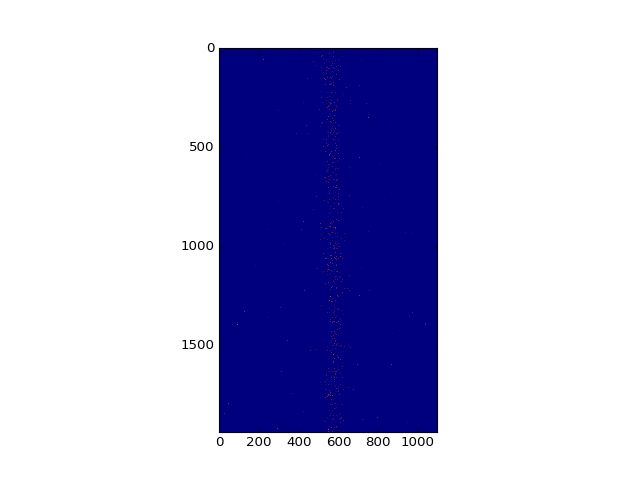

In [48]:
focus6.update()

In [10]:
focus3.run.counts_per_second()

703.28792442461372

In [44]:
cropping_tool(focus5,200,2300,rebin=3)

In [49]:
cmplot(np.transpose(focus6.run.get_array()),smooth=5)

In [13]:
def fwhm_vs_row_plot(datarun,step=100):
    plt.plot(*list(zip(*[(i+step/2,fwhm_datarun(datarun.run,2300,xrange=[i,i+step],rebin=2)) for i in range(0,2000,step)])),label='fwhm v row')
    plt.show()

stopped acquisistion


In [54]:
fwhm_vs_row_plot(focus6,step=200)

In [75]:
[plot_with_energy_scale(x.run,2300,known_bin=300,label='ZnS',rebin=2,
                       xrange=[800,1300],show=False,calcfwhm=True,peaknormalize=False)
 for x in (focus3,focus4,focus5,focus6,focus7,focus8,focus9)]
plt.show()

In [74]:
focus9.run.acquisition_time()

60.086976766586304

In [62]:
focus_ZvsFWHM_plot((focus6,focus7,focus3,focus4,focus5),2300,xrange=[900,1500],rebin=2,known_bin=250)

In [71]:
cropping_tool(focus4,200,2300,rebin=3)

stopped acquisistion


# Begin Fine focusing

In [76]:
finefocus0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'finefocus0.9.15',htime='10m')
finefocus0.run.z=0

starting acquisition


In [122]:
finefocus1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'finefocus1.9.15',htime='10m')
finefocus1.run.z=1

starting acquisition


In [148]:
finefocus1.run.acquisition_time()

600.0941395759583

<IPython.core.display.Javascript object>


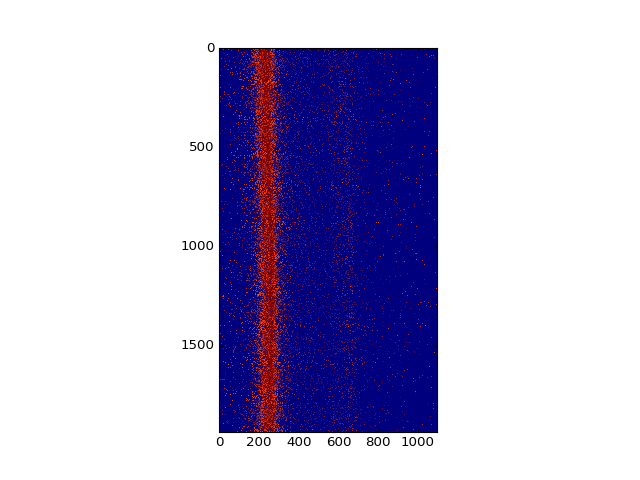

In [149]:
finefocus1.update()

In [151]:
cropping_tool(finefocus1,200,2300,rebin=1)

In [153]:
fwhm_vs_row_plot(finefocus1,step=100)

In [156]:
plot_with_energy_scale(finefocus0.run,2300,known_bin=300,label='ZnS',rebin=1,
                           xrange=[1000,1200],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(finefocus1.run,2300,known_bin=300,label='ZnS',rebin=1,
                           xrange=[1000,1200],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

In [144]:
finefocus1.run.acquisition_time()

326.32845878601074

<IPython.core.display.Javascript object>


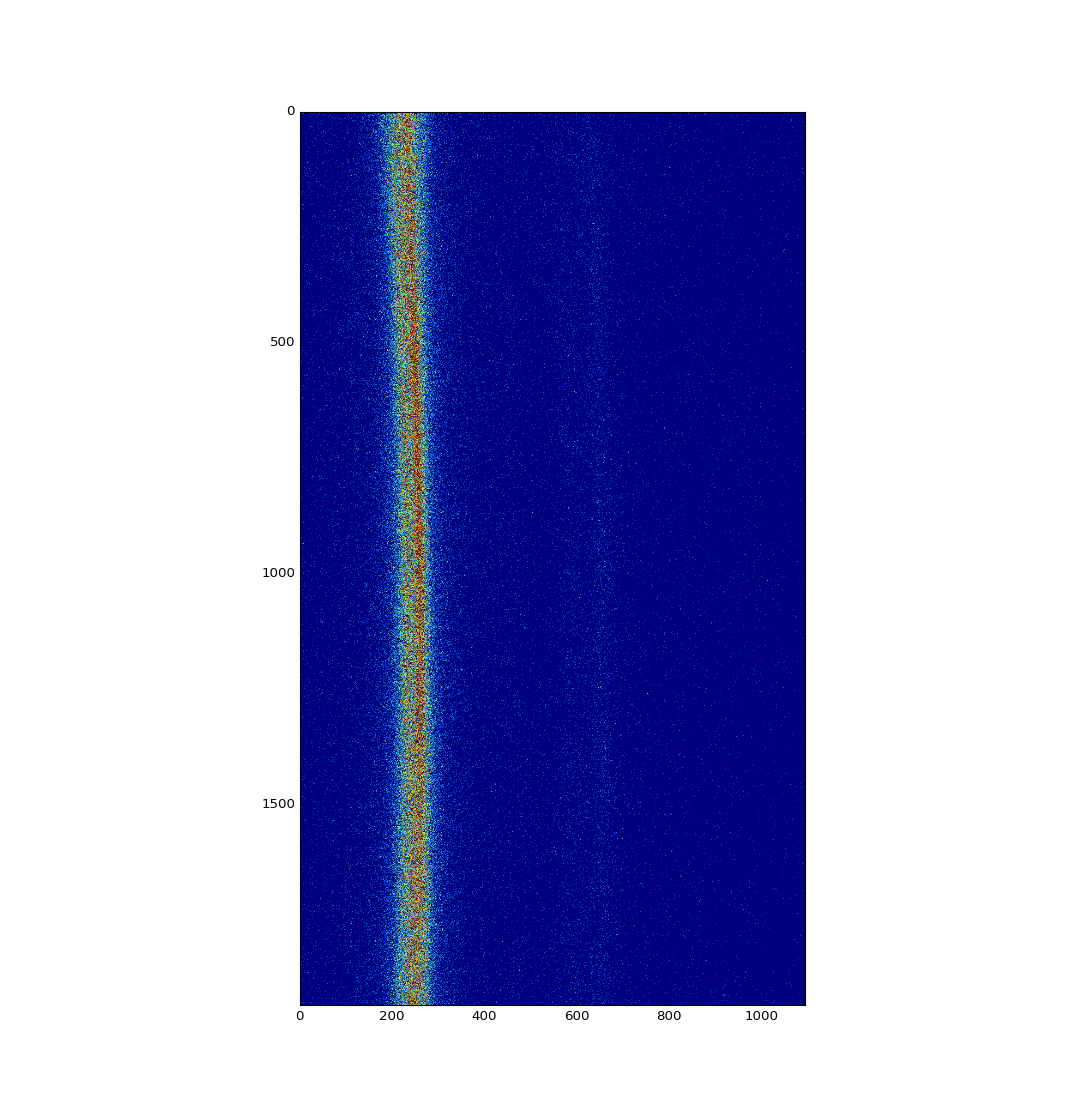

In [157]:
finefocus1.run.show(vmax=500)

<IPython.core.display.Javascript object>


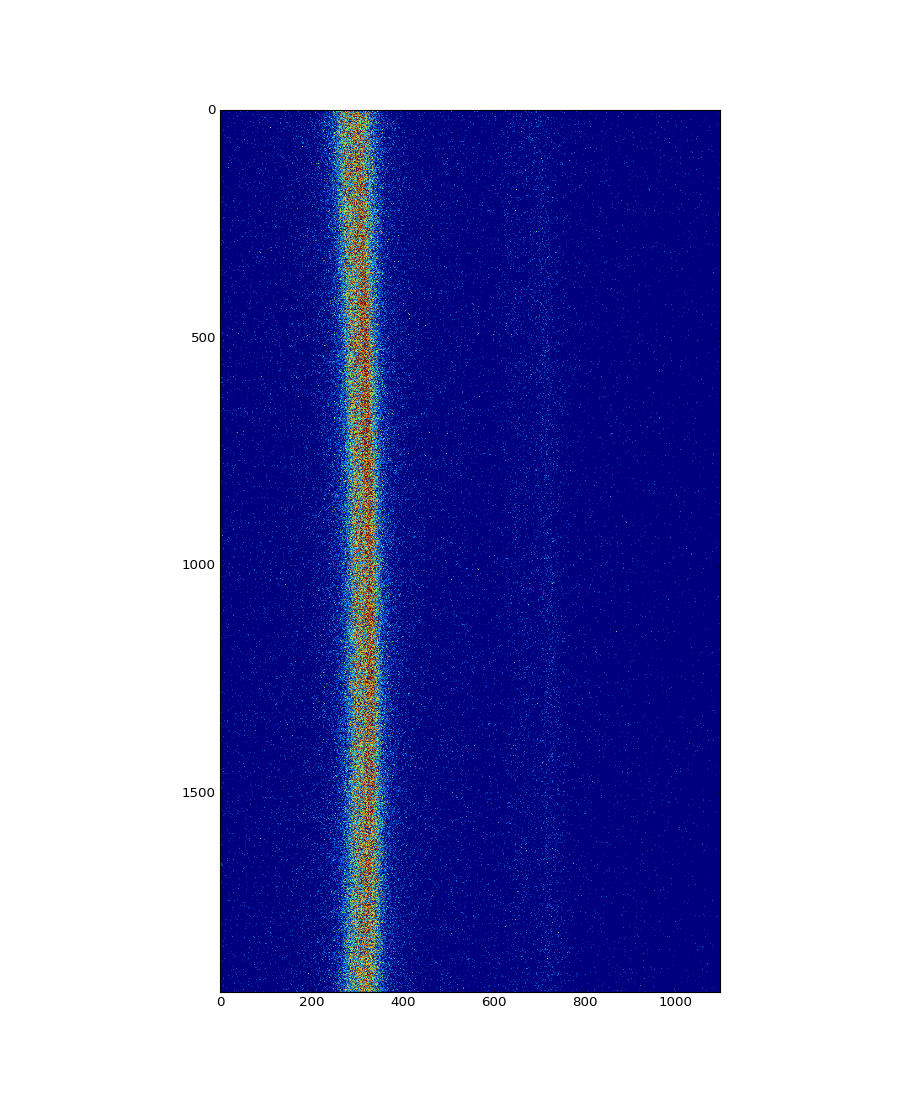

In [97]:
finefocus0.run.show(vmax=500)

In [158]:
cmplot(np.transpose(finefocus1.run.get_array()),smooth=4)

In [115]:
plot_parabolic_energy_scale_rebin(58.9,finefocus0.run,label=None,show=False,yupper=200,ylower=425,xleft=1000,xright=1200,
xpixelshift=0,smooth=2,rebinparam=1)
plt.show()

In [105]:
normalize = lambda x: x/max(x)

<IPython.core.display.Javascript object>


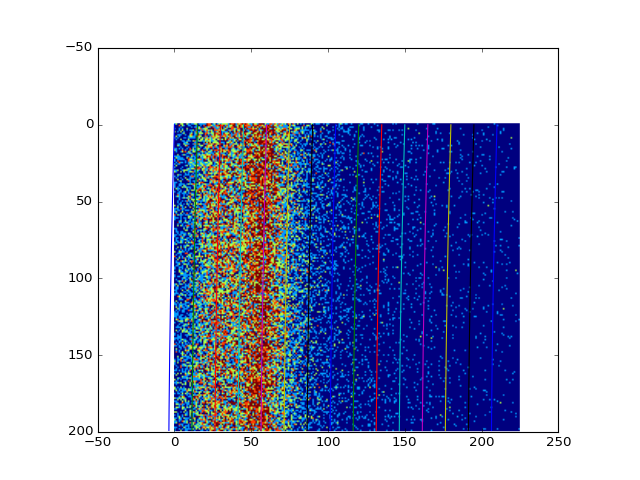

-5.18618165607e-05 0.0283171940111 -54.3146810397


array([10916, 14151, 13765, 15143, 15280, 17808, 17489, 19358, 23277,
       21637, 21486, 24109, 26515, 27878, 31908, 33482, 30003, 35653,
       42931, 44056, 46023, 49513, 47115, 47527, 55113, 54137, 53360,
       55739, 52270, 59050, 58173, 56659, 60142, 55629, 54872, 52668,
       49608, 50741, 59824, 51713, 57961, 53151, 56787, 59283, 61776,
       61772, 63747, 70098, 72017, 79772, 76554, 82934, 80627, 91270,
       92725, 88787, 91952, 84639, 88680, 83803, 88881, 78257, 72899,
       71194, 68995, 57230, 59340, 57331, 48907, 43173, 41715, 40119,
       37326, 31529, 25926, 27905, 24825, 26454, 23215, 23089, 19816,
       18353, 18151, 17211, 15406, 14512, 14013, 13688, 13933, 12552,
        9426, 10116,  8131,  9515,  8420, 10049,  7020,  5999,  8599,
        6782,  6526,  6146,  5640,  5778,  6133,  6842,  5011,  5633,
        4617,  4510,  4900,  3782,  3498,  3896,  4521,  2900,  3772,
        4398,  3533,  4264,  3530,  3874,  2903,  3387,  2121,  2893,
        1865,  3749,

In [160]:
dofit(np.transpose(finefocus1.run.get_array()[200:425,1000:1200]))

In [165]:
finefocus0.run.counts_per_second()

700.27102613579063

In [164]:
finefocus1.run.counts_per_second()

676.46461714790541

# Perhaps angular alignment of sample position would help with peak shape.

In [161]:
angle0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'angle0.9.15',htime='5m')
angle0.run.theta=130
angle0.run.z=0

starting acquisition


In [182]:
angle1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'angle1.9.15',htime='5m')
angle1.run.theta=140
angle0.run.z=0

starting acquisition


In [201]:
angle2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'angle2.9.15',htime='5m')
angle2.run.theta=145
angle2.run.z=0

starting acquisition


In [216]:
angle3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'angle3.9.15',htime='5m')
angle3.run.theta=150
angle3.run.z=0

starting acquisition


In [224]:
angle4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'angle4.9.15',htime='5m')
angle4.run.theta=155
angle4.run.z=0

starting acquisition


In [225]:
angle4.run.acquisition_time()

5.006387948989868

In [226]:
[x.run.counts_per_second() for x in (angle0,finefocus0,angle1,angle2,angle3,angle4)]

[404.21917631279308,
 700.27102613579063,
 872.75412249582712,
 973.08479194298957,
 968.41324109149741,
 596.37943173981353]

In [185]:
plot_with_energy_scale(finefocus0.run,2300,known_bin=None,label='ZnS0',rebin=2,
                           xrange=[1000,1200],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(finefocus1.run,2300,known_bin=None,label='ZnS1',rebin=2,
                           xrange=[1000,1200],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(angle0.run,2300,known_bin=None,label='ZnS - 135deg',rebin=2,
                           xrange=[1100,1500],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

In [234]:
[plot_with_energy_scale(x.run,2300,known_bin=None,label='ZnS - 135deg',rebin=1,
                           xrange=[800,1200],show=False,calcfwhm=True,peaknormalize=True)
 for x in (finefocus0,finefocus1,angle0,angle1,angle2,angle3,angle4)]
plt.show()

In [231]:
fwhm_vs_row_plot(finefocus1,step=100)

In [230]:
fwhm_vs_row_plot(angle4,step=100)

# Hmm noticed some noise on right side of sensor
* All data has been at 25kV @ 1.5mA

In [236]:
finefocus2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'finefocus2.9.15',htime='10m')
finefocus2.run.theta=145
finefocus2.run.z=0

starting acquisition


In [238]:
finefocus2.run.counts_per_second()

951.51865086624321

<IPython.core.display.Javascript object>


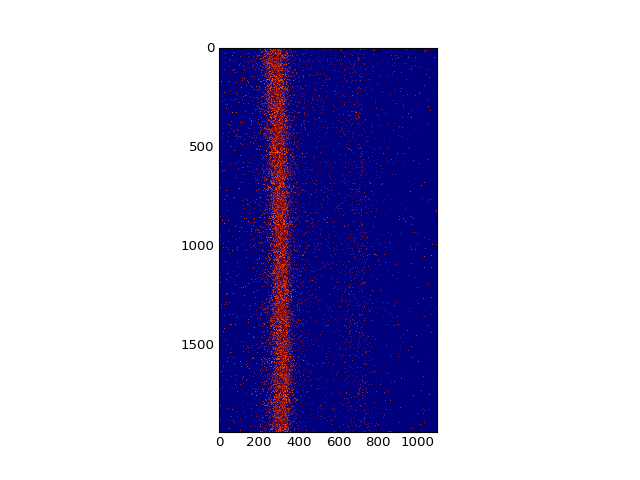

In [242]:
finefocus2.update()

In [246]:
cropping_tool(finefocus2,200,2300,rebin=1)

In [248]:
finefocus2.run.acquisition_time()

573.7185595035553

stopped acquisistion


# Shielding seems to have blocked noise on right side, back to focusing

In [236]:
finefocus3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'finefocus3.9.15',htime='10m')
finefocus3.run.theta=145
finefocus3.run.z=0

starting acquisition
